<a href="https://colab.research.google.com/github/angelotc/metric-learning-LMNN-kNN-Example/blob/main/metric_learn_skunkworks_binary_classification_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/johny-c/metric-learn.git@lmnn
import matplotlib.pyplot as plt

from sklearn.datasets import make_friedman1
import pandas as pd
import numpy as np


def friedman_np_to_df(X,y):
  return pd.DataFrame(X,columns=['x0','x1', 'x2', 'x3', 'x4']), pd.Series(y)

# Make training set. We don't care about Y so call it NA.
X_train, NA1 = make_friedman1(n_samples=1000, n_features=5, random_state = 1) 
X_train, NA1 = friedman_np_to_df(X_train,NA1)

#categorize training set based off of x0
domain_list = []
for i in range(len(X_train)):
  if X_train.iloc[i]['x0'] < 0.6 :
    domain_list.append(1)
  else:
    domain_list.append(0)


X_train['domain'] = domain_list

# Set training set to where domain == 1 (x0 < 0.6), but also add ~60 out-of-domain samples (X_train['domain'] == 1 )

out_of_domain = X_train[X_train['domain'] == 0][:60]
X_train =  X_train[X_train['domain']==1]
X_train = pd.concat([out_of_domain, X_train])
y_train = X_train.copy()
X_train = X_train.drop(columns = ['domain'])
y_train = y_train['domain']



# Make testing set with a different random_state
X_test, NA2 = make_friedman1(n_samples=1000, n_features=5, random_state = 3)
X_test, NA2 = friedman_np_to_df(X_test,NA2)


#categorize testing set based off of x0
domain_list = []
for i in range(len(X_test)):
  if X_test.iloc[i]['x0'] < 0.6:
    domain_list.append(1)
  else:
    domain_list.append(0)
X_test['domain'] = domain_list

y_test = X_test['domain'].copy()
X_test = X_test.drop(columns = ['domain'])


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from metric_learn import LMNN
lmnn_knn = Pipeline(steps=[('lmnn', LMNN()), ('knn', KNeighborsClassifier())])
# new implementation version
parameters = {
              'lmnn__n_neighbors':[2,3],
              'knn__n_neighbors':[2,3],
              'knn__weights': ['uniform','distance'],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__leaf_size': [28,30,32],
              'knn__metric': [ 'manhattan', 'mahalanobis', 'minkowski']}
# Main version
# parameters = {'lmnn__init': ['pca', 'lda', 'identity', 'random'],
#               'lmnn__k':[2,3],
#               'knn__n_neighbors':[2,3],
#               'knn__weights': ['uniform','distance'],
#               'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'knn__leaf_size': [28,30,32],
#               'knn__metric': [ 'manhattan', 'mahalanobis', 'minkowski']}
grid_lmnn_knn = GridSearchCV(lmnn_knn, parameters,cv = 5, n_jobs=-1, verbose=True, scoring='roc_auc')
results = gs.cv_results_.fit(np.array(X_train),np.array(y_train))
grid_lmnn_knn.score(np.array(X_test), np.array(y_test))




Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.5min finished


0.9274757514827321

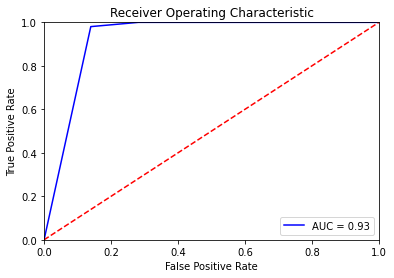

In [ ]:

# PLOT Curve

from sklearn.metrics import roc_curve,auc
y_prob = grid_lmnn_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()